# 1. Imports & Config

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import ndarray
from matplotlib.pyplot import subplots, show
from sklearn.model_selection import train_test_split

# model building imports
import keras
from keras import Model, Sequential, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import LeakyReLU
from keras.ops import add
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler ,ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical

import keras_tuner
# augmentation operations
from keras.layers import RandomBrightness, RandomFlip, RandomRotation
from keras.layers import Pipeline
from keras.layers import BatchNormalization
from keras.layers import Dropout

In [2]:
import tensorflow as tf

# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)


Available GPUs: []


In [3]:
print('num gpus:', len(tf.config.list_physical_devices('GPU')))

num gpus: 0


In [4]:
# importing the dataset
metadata = pd.read_csv('../Data/rare_species/metadata.csv')
metadata.sample(5)

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
7081,d8f82a02-3149-436b-92ba-043d0f5fd29b,29343352,1055122,animalia,chordata,agamidae,chordata_agamidae/29343352_1055122_eol-full-si...
10935,a8ef6140-7a61-42e4-8fe4-afe55c06a2fc,20197412,45276321,animalia,cnidaria,acroporidae,cnidaria_acroporidae/20197412_45276321_eol-ful...
5108,2951794e-e24d-42de-8b8d-d9db84740a75,21051967,1018932,animalia,chordata,rhacophoridae,chordata_rhacophoridae/21051967_1018932_eol-fu...
9850,d45f6a01-d1e4-475c-8176-5582485e0b2a,2752411,45275716,animalia,cnidaria,dendrophylliidae,cnidaria_dendrophylliidae/2752411_45275716_eol...
4811,4a87b417-d3ac-4d30-82c2-b14402f51f9a,22332519,794627,animalia,chordata,gavialidae,chordata_gavialidae/22332519_794627_eol-full-s...


In [5]:
# applying the filepath
metadata['file_path'] = metadata['file_path'].apply(lambda x: os.path.join('../Data/rare_species', x))

In [6]:
metadata.sample(5)

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
4238,6b6e7705-d106-4649-8256-f79655bae2d4,28508513,323914,animalia,chordata,atelidae,../Data/rare_species\chordata_atelidae/2850851...
4764,496d7f62-0659-4b77-b8bf-9c85b765ff1f,29543406,1018932,animalia,chordata,rhacophoridae,../Data/rare_species\chordata_rhacophoridae/29...
10991,8188bb2f-e849-4bd1-a816-1696012ab875,20738647,46559412,animalia,chordata,pontoporiidae,../Data/rare_species\chordata_pontoporiidae/20...
10043,d13cd8d5-5ff0-4996-bbcc-892f56547dfd,2752492,46561068,animalia,chordata,urolophidae,../Data/rare_species\chordata_urolophidae/2752...
118,e9f3d7db-210c-41b7-b116-d79e2f129d1b,8782006,1057320,animalia,chordata,anguidae,../Data/rare_species\chordata_anguidae/8782006...


# 2.  Preprocessing

In [7]:
metadata.phylum.unique()

array(['mollusca', 'chordata', 'arthropoda', 'echinodermata', 'cnidaria'],
      dtype=object)

In [8]:
print(metadata['family'].value_counts())

family
dactyloidae        300
cercopithecidae    300
formicidae         291
carcharhinidae     270
salamandridae      270
                  ... 
cyprinodontidae     30
alligatoridae       30
balaenidae          30
goodeidae           30
siluridae           29
Name: count, Length: 202, dtype: int64


In [9]:
num_classes = metadata['family'].nunique()
num_classes

202

our dataset is inbalaced and has a length of 202 classes

In [10]:
# Transforming our target and feature into a int
metadata['target'] = metadata['family'].astype('category').cat.codes
metadata['feat'] = metadata['phylum'].astype('category').cat.codes

In [11]:
metadata['target'].sample(10)

7685     45
8788     64
2458     38
9586     23
6040     21
3261    175
6546     25
8375     19
4728      0
2789    163
Name: target, dtype: int16

### Spliting the data

In [12]:
# SSpliting the data while keeping the same distribuition of classes(target) - 70%/20%/10%

train, temp = train_test_split(metadata, test_size=0.3,stratify=metadata['target'],random_state=1)

val, test = train_test_split(temp,test_size=1/3,stratify=temp['target'],random_state=1)

In [13]:
train.shape , val.shape , test.shape

((8388, 9), (2396, 9), (1199, 9))

Loading the images

In [14]:
def load_image(df, path='file_path', label='target', image_size=(256, 256)):
    X = []
    y = []

    for _, row in df.iterrows():
        image = keras.utils.load_img(row[path], target_size=image_size)
        input_arr = keras.utils.img_to_array(image) / 255.0  # Normalize
        X.append(input_arr)
        y.append(row[label])
    
    return np.array(X), np.array(y)

In [15]:
X_train , y_train = load_image(train)
X_val , y_val = load_image(val)
X_test , y_test = load_image(test)

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [16]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((8388, 256, 256, 3),
 (8388,),
 (2396, 256, 256, 3),
 (2396,),
 (1199, 256, 256, 3),
 (1199,))

In [17]:
# one-hot encoding the target
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [18]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((8388, 256, 256, 3),
 (8388, 202),
 (2396, 256, 256, 3),
 (2396, 202),
 (1199, 256, 256, 3),
 (1199, 202))

# 3. Models

In [19]:
augmentation_layer = Sequential(
    [
        RandomBrightness(factor=0.2, value_range=(0.0, 1.0)),
        RandomFlip(),
        RandomRotation(factor=0.2, fill_mode="reflect")
    ], 
    name="augmentation_layer")


In [20]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0, verbose = 1)

In [21]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights = True)

In [22]:
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy]

In [23]:
input_shape = (256,256,3)

epochs = 200
batch_size = 32

## Model 1

In [24]:
def build_transfg_like(input_shape=input_shape, num_classes=num_classes):
    model = Sequential([
        Input(shape=input_shape),
        
        augmentation_layer,
        
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        
        Dense(256, activation="relu"),
        Dropout(0.5),
        
        Dense(num_classes, activation="softmax")
    ], 
        name="TransFG_CNN")
    
    model.summary()
    
    return model

In [25]:
model_1 = build_transfg_like()

model_1.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "TransFG_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 202)            │        51,914 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,699,850 (128.55 MB)

 Trainable params: 33,699,850 (128.55 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# train the model
_1 = model_1.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks= [lr_reduction , early_stop]
)

Epoch 1/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 76s 286ms/step - accuracy: 0.0163 - loss: 5.2531 - val_accuracy: 0.0405 - val_loss: 5.1209 - learning_rate: 0.0100
Epoch 2/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 74s 280ms/step - accuracy: 0.0262 - loss: 5.1160 - val_accuracy: 0.0351 - val_loss: 5.0209 - learning_rate: 0.0100
Epoch 3/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 74s 281ms/step - accuracy: 0.0388 - loss: 5.0657 - val_accuracy: 0.0555 - val_loss: 4.9883 - learning_rate: 0.0100
Epoch 4/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 74s 280ms/step - accuracy: 0.0438 - loss: 5.0417 - val_accuracy: 0.0518 - val_loss: 4.9629 - learning_rate: 0.0100
Epoch 5/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 74s 282ms/step - accuracy: 0.0485 - loss: 5.0072 - val_accuracy: 0.0760 - val_loss: 4.9286 - learning_rate: 0.0100
Epoch 6/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 78s 296ms/step - accuracy: 0.0564 - loss: 4.9732 - val_accuracy: 0.0768 - val_loss: 4.9016 - learning_rate: 0.0100
Epoch 7/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 75s 286ms/step - accura

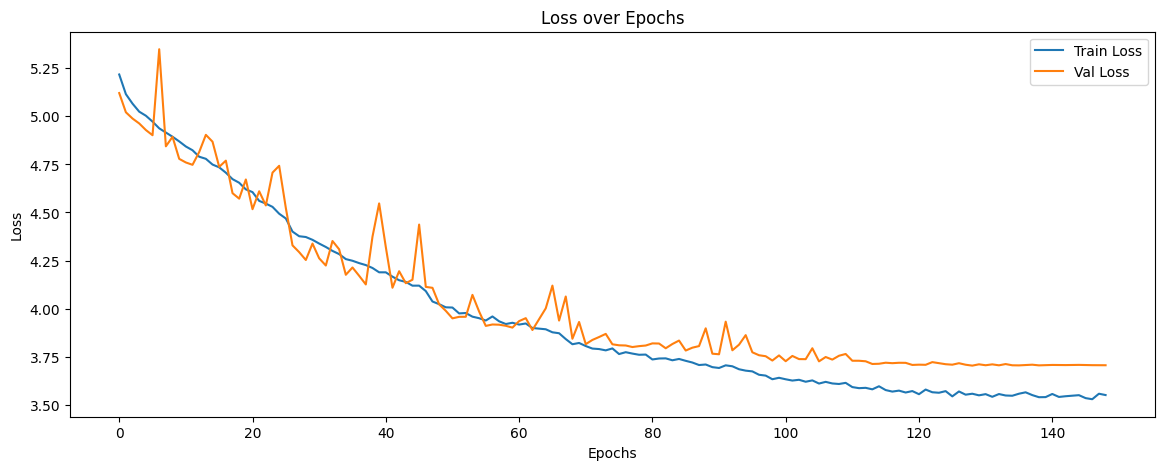

In [27]:
plt.figure(figsize=(14, 5))

plt.plot(_1.history['loss'], label='Train Loss')
plt.plot(_1.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


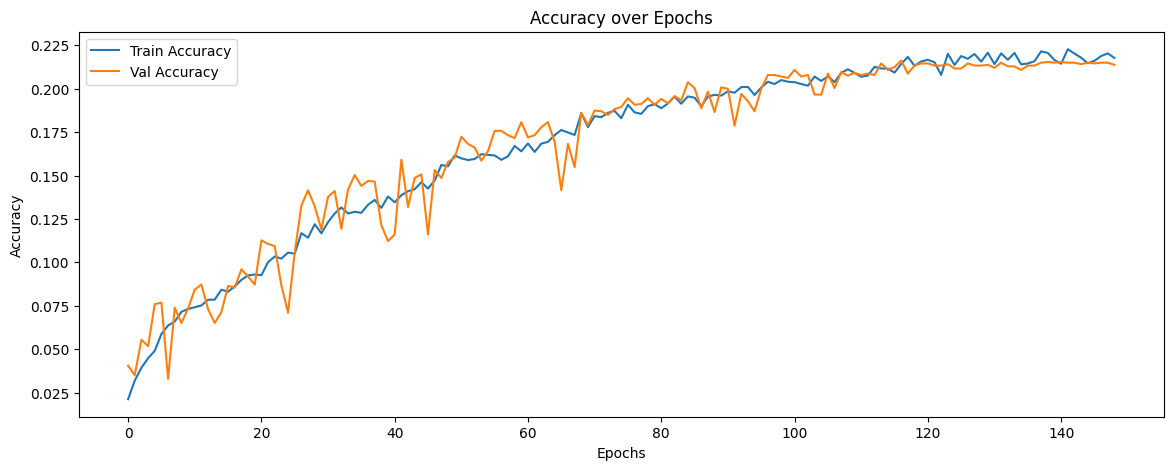

In [28]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.plot(_1.history['accuracy'], label='Train Accuracy')
plt.plot(_1.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

## Model 2

In [36]:
def build_ffvt(input_shape=input_shape, num_classes=num_classes):
    model = Sequential([
        Input(shape=input_shape),
        augmentation_layer,
        
        Conv2D(32, (3, 3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),
        
        Conv2D(256, (3, 3), padding="same", activation="relu"),  # extra layer to simulate fusion
        MaxPooling2D((2, 2)),
        
        Flatten(),
        
        Dense(512, activation="relu"),
        
        Dense(num_classes, activation="softmax"),
    ], 
        name="FFVT_Sequential")
    
    model.summary()
    
    return model

In [47]:
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy]

In [49]:
model_2 = build_ffvt()

model_2.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "FFVT_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,046,986 (129.88 MB)

 Trainable params: 34,046,986 (129.88 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
X_train.dtype

dtype('float32')

In [43]:
tf.config.run_functions_eagerly(True)

In [50]:
# train the model
_2 = model_2.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks= [lr_reduction , early_stop]
)

Epoch 1/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 164s 624ms/step - accuracy: 0.0203 - loss: 5.1822 - val_accuracy: 0.0225 - val_loss: 5.0796 - learning_rate: 0.0100
Epoch 2/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 155s 591ms/step - accuracy: 0.0248 - loss: 5.0533 - val_accuracy: 0.0179 - val_loss: 5.0353 - learning_rate: 0.0100
Epoch 3/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 153s 582ms/step - accuracy: 0.0339 - loss: 5.0329 - val_accuracy: 0.0209 - val_loss: 5.0359 - learning_rate: 0.0100
Epoch 4/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 153s 580ms/step - accuracy: 0.0335 - loss: 5.0169 - val_accuracy: 0.0518 - val_loss: 4.9878 - learning_rate: 0.0100
Epoch 5/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 152s 580ms/step - accuracy: 0.0565 - loss: 4.9624 - val_accuracy: 0.0409 - val_loss: 5.0276 - learning_rate: 0.0100
Epoch 6/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 154s 585ms/step - accuracy: 0.0634 - loss: 4.9014 - val_accuracy: 0.0689 - val_loss: 4.8933 - learning_rate: 0.0100
Epoch 7/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 154s 584ms/step -

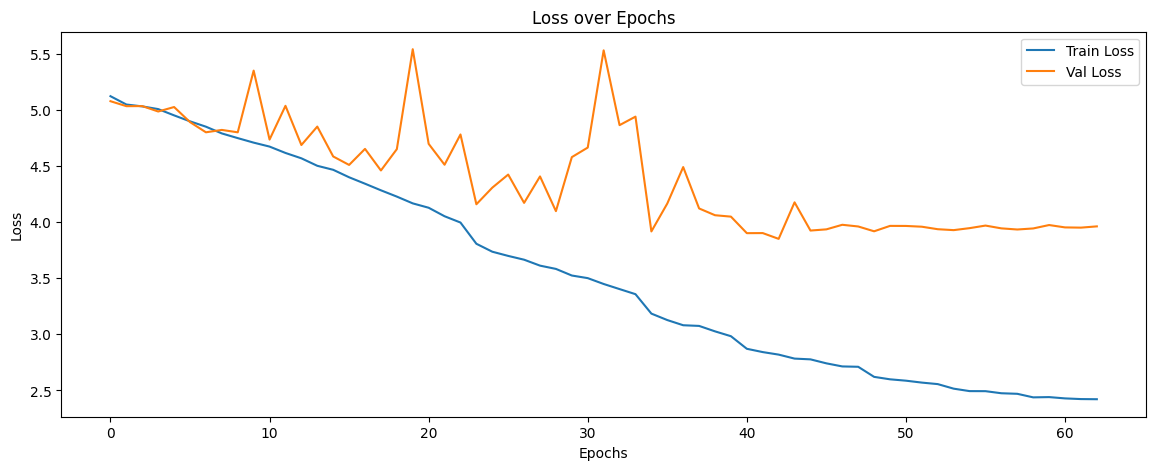

In [51]:
plt.figure(figsize=(14, 5))

# Plot loss
plt.plot(_2.history['loss'], label='Train Loss')
plt.plot(_2.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

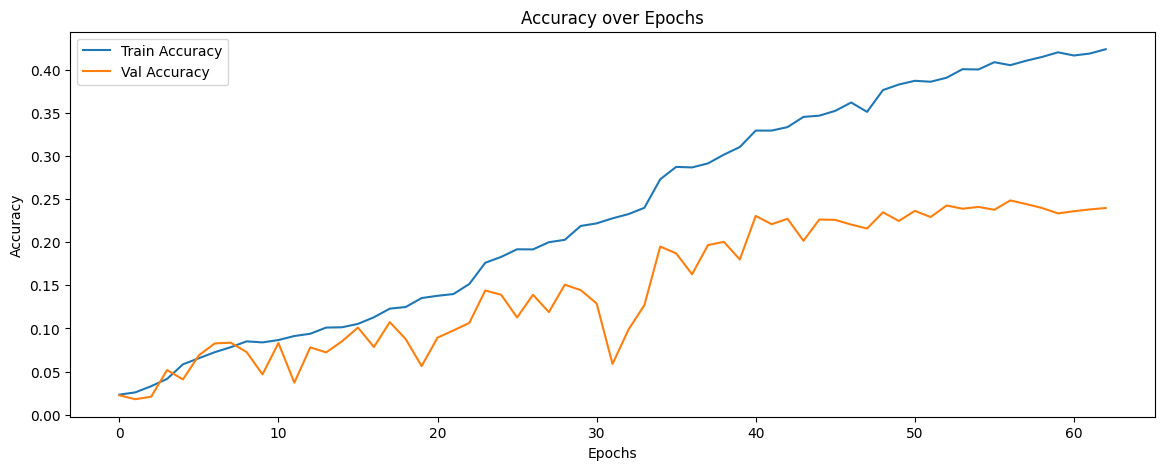

In [52]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.plot(_2.history['accuracy'], label='Train Accuracy')
plt.plot(_2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Model 3

In [53]:
def build_smvit(input_shape=input_shape, num_classes=num_classes):
    model = Sequential([
        Input(shape=input_shape),
        augmentation_layer,
        Dropout(0.2),  
        
        Conv2D(32, (3, 3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), padding="same", activation="relu"),
        
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(128, (3, 3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(512, activation='relu'),
        
        Dense(1024, activation="relu"),
        Dropout(0.5),
        
        
        Dense(num_classes, activation="softmax"),
    ],
        name="SMViT_Sequential")
    
    model.summary()
    
    return model

In [54]:
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy]

In [55]:
model_3 = build_smvit()

model_3.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "SMViT_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 202)            │       207,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,934,986 (259.15 MB)

 Trainable params: 67,934,986 (259.15 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# train the model
_3 = model_3.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks= [lr_reduction , early_stop]
)

Epoch 1/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 150s 571ms/step - accuracy: 0.0159 - loss: 5.2215 - val_accuracy: 0.0250 - val_loss: 5.1829 - learning_rate: 0.0100
Epoch 2/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 148s 564ms/step - accuracy: 0.0274 - loss: 5.0894 - val_accuracy: 0.0326 - val_loss: 5.1846 - learning_rate: 0.0100
Epoch 3/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 148s 564ms/step - accuracy: 0.0276 - loss: 5.0616 - val_accuracy: 0.0380 - val_loss: 5.1294 - learning_rate: 0.0100
Epoch 4/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 148s 564ms/step - accuracy: 0.0335 - loss: 5.0419 - val_accuracy: 0.0384 - val_loss: 5.0881 - learning_rate: 0.0100
Epoch 5/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 150s 570ms/step - accuracy: 0.0420 - loss: 4.9892 - val_accuracy: 0.0463 - val_loss: 5.0773 - learning_rate: 0.0100
Epoch 6/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 153s 581ms/step - accuracy: 0.0504 - loss: 4.9750 - val_accuracy: 0.0467 - val_loss: 4.9875 - learning_rate: 0.0100
Epoch 7/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 151s 575ms/step -

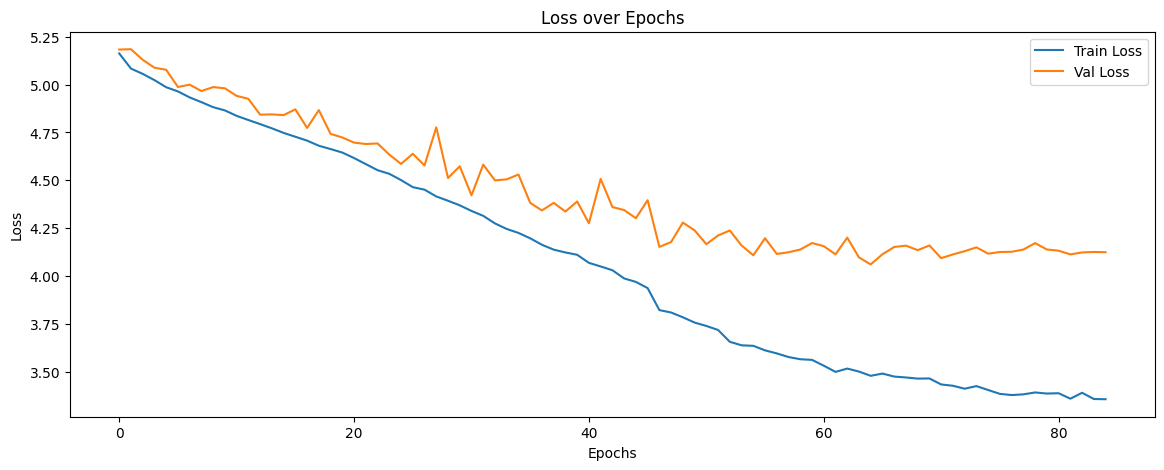

In [57]:
plt.figure(figsize=(14, 5))

# Plot loss
plt.plot(_3.history['loss'], label='Train Loss')
plt.plot(_3.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

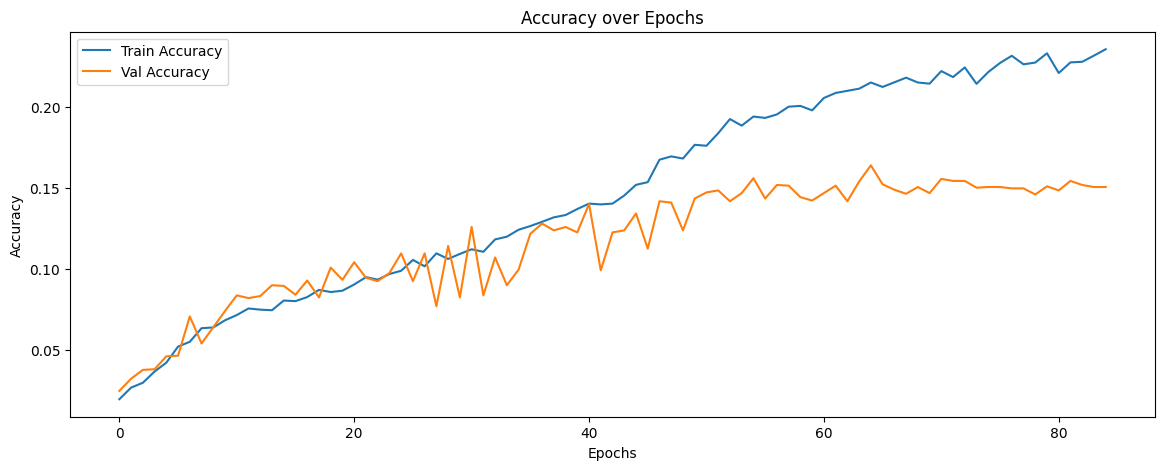

In [58]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.plot(_3.history['accuracy'], label='Train Accuracy')
plt.plot(_3.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()